In [1]:
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import spacy
from numpy import zeros, column_stack
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

nlp = spacy.load("en_core_web_lg")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

/Users/dnapolitano/miniconda3/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_lg' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.6.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
df = pandas.read_csv("troon_instagram_post_beer_attributes.csv")
df

,id,attribute,count
0,203,coffee,1
1,203,conditioned,1
2,203,imperial,1
3,203,imperial milk stout,1
4,203,milk,1
...,...,...,...
1734,414,ale,1
1735,414,hoppy ale,1
1736,415,hoppy,1
1737,415,ale,1


In [3]:
vectors = []
attributes = sorted(set(df["attribute"]))

for attribute in attributes:
    tokens = attribute.lower().split(" ")
    if len(tokens) == 1:
        vectors.append(nlp(tokens[0]).vector)
    else:
        v = nlp(tokens[0]).vector
        for t in tokens[1:]:
            if t != "&":
                v = v + nlp(t).vector
        vectors.append(v)

In [4]:
len(vectors)

284

---

In [5]:
# TODO: Come back to this.  The maximum silhouette score is terrible and agglomerative clustering didn't really help.
# cluster_sizes = []
# silhouettes = []

# for i in range(3, len(vectors) // 2):
#     cluster_sizes.append(i)
#     kmeans = KMeans(n_clusters=i, random_state=1024).fit(vectors)
#     silhouettes.append(silhouette_score(vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
# g = sns.lineplot(x=cluster_sizes, y=silhouettes)

In [6]:
# cluster_sizes[silhouettes.index(max(silhouettes))]

In [7]:
# kmeans = KMeans(n_clusters=cluster_sizes[silhouettes.index(max(silhouettes))], random_state=1024).fit(vectors)

# tsne = TSNE(n_components=2, random_state=1024, metric="cosine")
# reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(vectors)))
# ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
# plt.show()

In [8]:
# sorted(list(zip(attributes, kmeans.labels_)), key=lambda x : x[1])

---

In [9]:
attribute_vectors = dict(zip(attributes, vectors))
beer_ids = sorted(set(df["id"]))
beer_vectors = []

for beer_id in beer_ids:
    vector = zeros(300)
    for (i, row) in df[df["id"] == beer_id].iterrows():
        for j in range(0, row["count"]):
            vector = vector + attribute_vectors[row["attribute"]]
    beer_vectors.append(vector)

Text(0, 0.5, 'Silhouette Score')

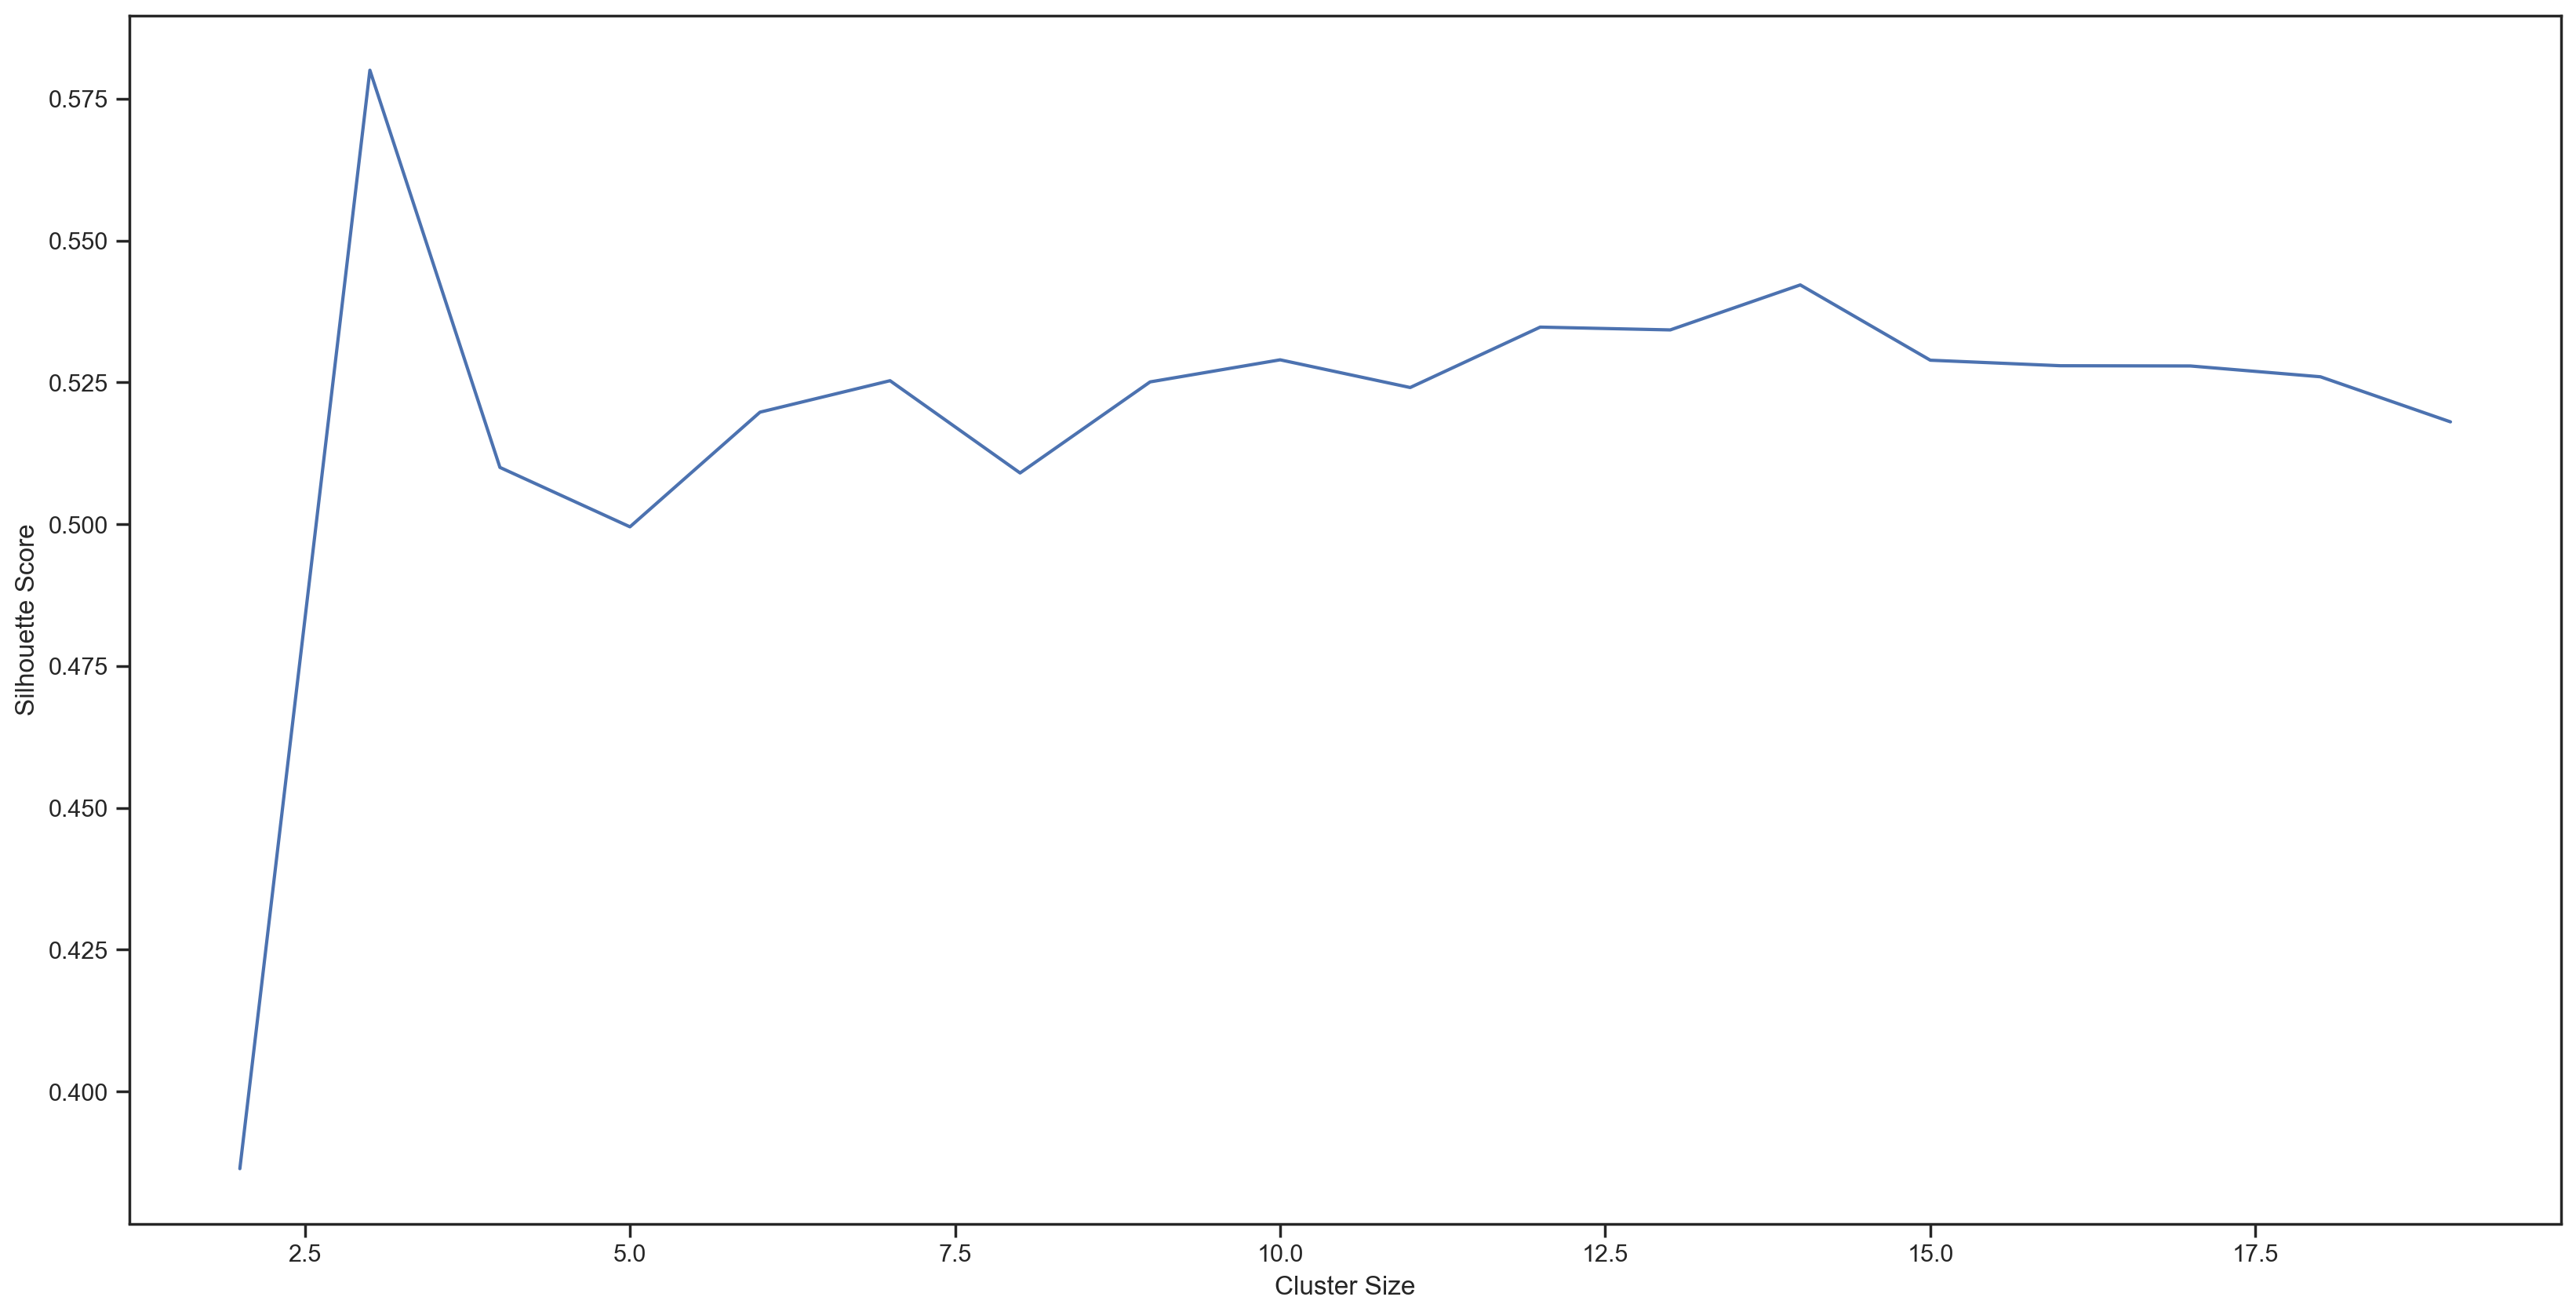

In [10]:
cluster_sizes = []
silhouettes = []

for i in range(2, 20):
    cluster_sizes.append(i)
    kmeans = KMeans(n_clusters=i, random_state=1024, n_init="auto").fit(beer_vectors)
    silhouettes.append(silhouette_score(beer_vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
g = sns.lineplot(x=cluster_sizes, y=silhouettes)
g.set_xlabel("Cluster Size")
g.set_ylabel("Silhouette Score")

In [11]:
list(zip(cluster_sizes, silhouettes))

[(2, 0.3863939614758217),
 (3, 0.5800318006171856),
 (4, 0.5100163832340567),
 (5, 0.4995407324717934),
 (6, 0.5197535767025817),
 (7, 0.5253012270264598),
 (8, 0.5090322929124804),
 (9, 0.5250887169963803),
 (10, 0.528980079299801),
 (11, 0.5240963068958495),
 (12, 0.534746509060412),
 (13, 0.5342518978077698),
 (14, 0.542183998268372),
 (15, 0.528911605793172),
 (16, 0.5279382499015267),
 (17, 0.5278967699247192),
 (18, 0.525991612296054),
 (19, 0.5180440965655839)]

In [12]:
best_cluster_size = cluster_sizes[silhouettes.index(max(silhouettes))]
# best_cluster_size = 4
best_cluster_size

3

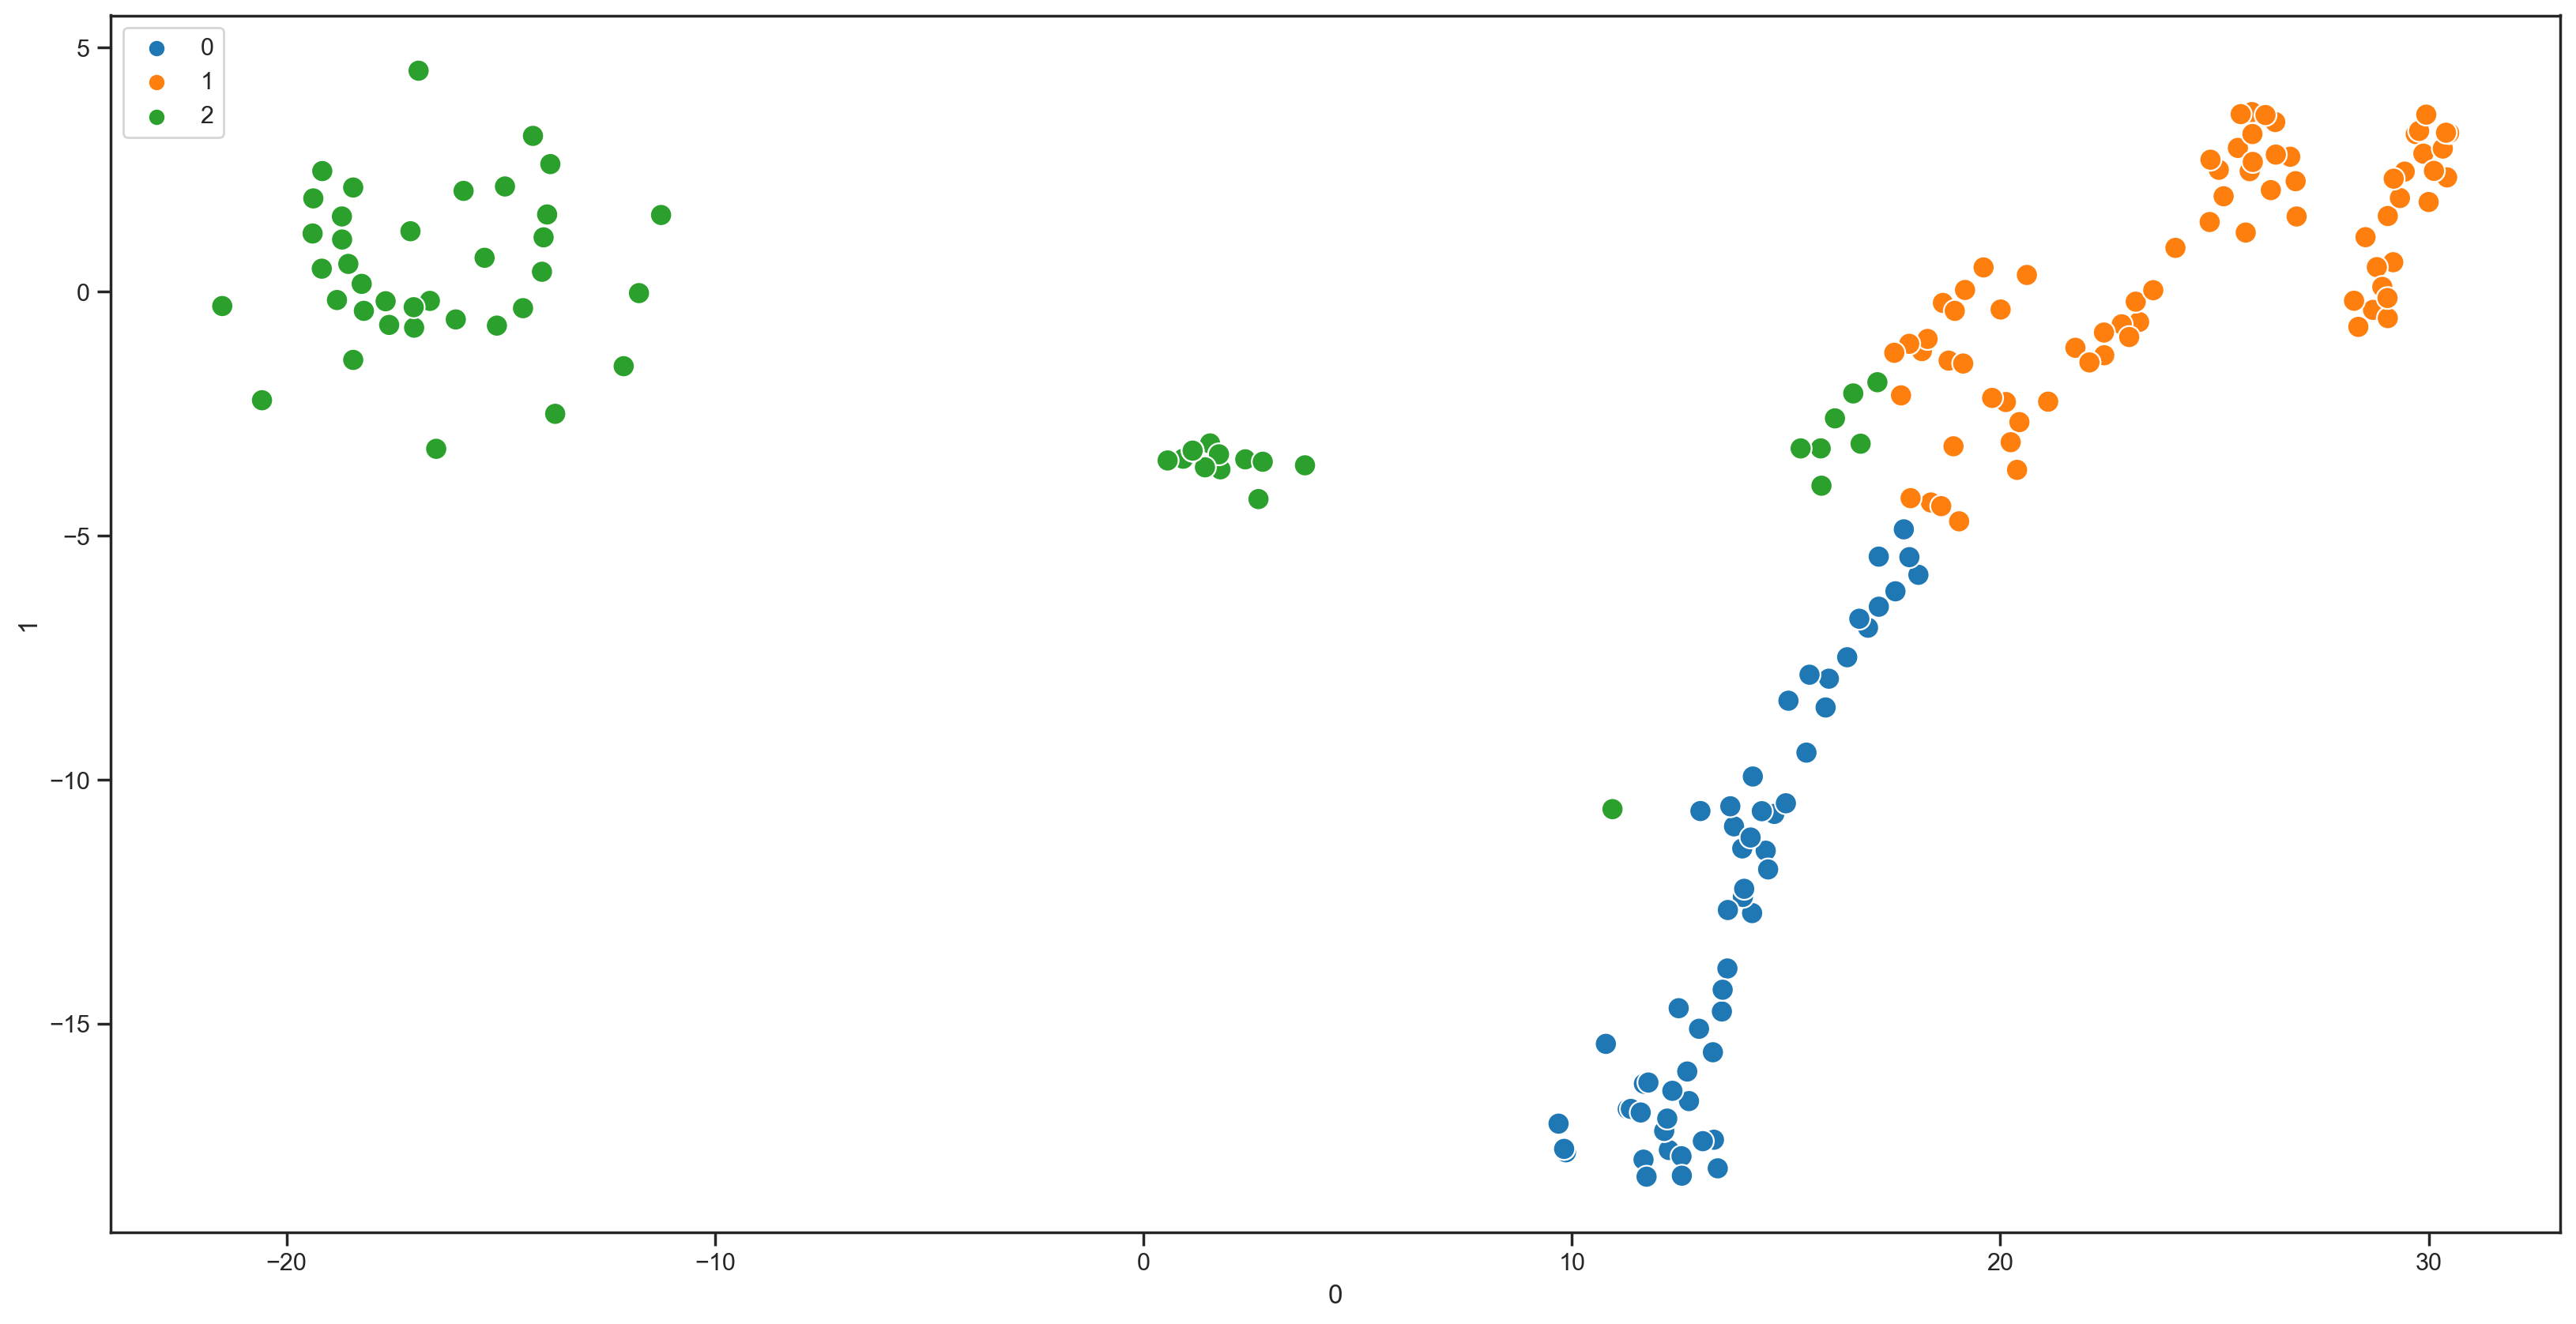

In [13]:
kmeans = KMeans(n_clusters=best_cluster_size, random_state=1024, n_init="auto").fit(beer_vectors)

tsne = TSNE(n_components=2, metric="cosine", perplexity=20, init="pca", random_state=1024, learning_rate="auto")
reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(beer_vectors)))
ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
plt.show()

In [14]:
cluster_attributes = {l : [] for l in set(kmeans.labels_)}
reduced["id"] = beer_ids
reduced["cluster_id"] = kmeans.labels_

for (i, row) in reduced.iterrows():
    attributes = list(df[df["id"] == row["id"]]["attribute"])
    cluster_attributes[row["cluster_id"]] += attributes

# appearing_in_all = None
# for cluster_id in cluster_attributes:
#     if appearing_in_all is None:
#         appearing_in_all = set(cluster_attributes[cluster_id])
#     else:
#         appearing_in_all = appearing_in_all.intersection(set(cluster_attributes[cluster_id]))
        
# print(appearing_in_all)
    
# {c : sorted(Counter([a for a in cluster_attributes[c] if a not in appearing_in_all]).items(), 
#             key=lambda x : x[1], reverse=True) for c in cluster_attributes}

{c : sorted(Counter(cluster_attributes[c]).items(), key=lambda x : x[1], reverse=True) for c in cluster_attributes}

{0: [('hopped', 20),
  ('conditioned', 15),
  ('ipa', 9),
  ('lactose', 9),
  ('@rojosroastery', 7),
  ('ale', 6),
  ('lupulin', 6),
  ('powder', 6),
  ('refermented', 6),
  ('lager', 6),
  ('session', 5),
  ('coffee', 5),
  ('simcoe', 4),
  ('mosaic', 4),
  ('citra', 4),
  ('hoppy', 4),
  ('imperial', 4),
  ('vanilla', 4),
  ('imperial stout', 4),
  ('stout', 4),
  ('american', 3),
  ('keller', 3),
  ('enigma', 3),
  ('galaxy', 3),
  ('madagascar vanilla', 3),
  ('porter', 3),
  ('oats', 2),
  ('azacca', 2),
  ('collaboration', 2),
  ('session ipa', 2),
  ('vic secret', 2),
  ('american varietals', 2),
  ('dry hopped', 2),
  ('amarillo', 2),
  ('fresh', 2),
  ('wheat', 2),
  ('pineapple', 2),
  ('triple', 2),
  ('triple ipa', 2),
  ('dipa', 2),
  ('cinnamon', 2),
  ('medusa', 2),
  ('pilsner', 2),
  ('fermented', 2),
  ('west coast', 2),
  ('baltic porter', 2),
  ('sour ale', 2),
  ('salt', 2),
  ('sea salt', 2),
  ('toasted coconut', 2),
  ('@thereferendbierblendery', 1),
  ('america

In [15]:
cluster_names = {0 : "IPAs Hopped/Conditioned", 1 : "Stouts and Sours", 2 : "Hoppy Ales"}

In [16]:
reduced["cluster_name"] = reduced["cluster_id"].apply(lambda x : cluster_names[x])

In [17]:
reduced["attributes"] = reduced["id"].apply(lambda x : ", ".join(sorted(df[df["id"] == x]["attribute"])))
reduced

,0,1,id,cluster_id,cluster_name,attributes
0,-16.919161,4.529945,0,2,Hoppy Ales,"ale, hoppy, hoppy ale"
1,-17.109098,1.240149,1,2,Hoppy Ales,"ale, hoppy, hoppy ale"
2,-16.507910,-3.218320,2,2,Hoppy Ales,"ale, hoppy, hoppy ale"
3,1.149047,-3.255546,3,2,Hoppy Ales,"ale, honey, hoppy, hoppy ale"
4,2.377422,-3.434097,6,2,Hoppy Ales,"ale, hoppy, hoppy ale, lactose, peach, referme..."
...,...,...,...,...,...,...
311,1.149047,-3.255546,411,2,Hoppy Ales,"ale, honey, hoppy, hoppy ale, refermented"
312,-16.919161,4.529945,412,2,Hoppy Ales,"ale, hoppy, hoppy ale"
313,-16.919161,4.529945,413,2,Hoppy Ales,"ale, hoppy, hoppy ale"
314,-16.919161,4.529945,414,2,Hoppy Ales,"ale, hoppy, hoppy ale"


In [18]:
reduced["cluster_name"].value_counts()

cluster_name
Hoppy Ales                 180
Stouts and Sours            76
IPAs Hopped/Conditioned     60
Name: count, dtype: int64